In [236]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [237]:
!pip install -q fastai==2.1.2

In [238]:
!pip install fastcore==1.3.1

  Using cached https://files.pythonhosted.org/packages/c5/2c/309e30e69731b59e04583d7e5986139d0e166c8ef00a759b2a43853f2ad1/fastcore-1.3.1-py3-none-any.whl
  Found existing installation: fastcore 1.3.13
    Uninstalling fastcore-1.3.13:
      Successfully uninstalled fastcore-1.3.13


In [239]:
from fastai import *
import pandas as pd
from fastai.tabular.all import *

In [240]:
from fastcore import __version__
print(__version__)

1.3.1


In [241]:
#hide
#skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

In [242]:
from fastai.tabular import *

In [243]:
train = pd.read_csv("/content/drive/My Drive/pisos_uniq.csv")
test = pd.read_csv("/content/drive/My Drive/pisos_test.csv")

In [244]:
test.fillna(value = test.mean(), inplace = True)

In [245]:
train.fillna(value = train.mean(), inplace = True)

In [246]:
train.drop("ID", axis = 1, inplace = True)
test.drop("ID", axis = 1, inplace = True)

In [247]:
train.head()

,Price,Sqft_m2,RatioEurM,Rooms,Toilets,Area,Elevator,Parking,Heating,CoolAir,Construction,Balcony
0,590000,70,8429,3.0,2.0,Esquerra Alta de l´Eixample,Yes,No,Yes,No,New,Yes
1,320000,105,3048,4.0,1.0,Guinardó,Yes,No,Yes,Yes,Not New,No
2,269000,76,3539,3.0,2.0,Guinardó,Yes,No,Yes,No,Not New,No
3,269000,76,3539,3.0,2.0,Guinardó,Yes,No,Yes,No,Not New,No
4,239000,79,3025,2.0,1.0,Congrés - Indians,Yes,No,Yes,Yes,Not New,No


In [248]:
dep_var = 'Price'

In [249]:
cat_names = [ 'Area','Elevator','Parking', 'Heating', 'CoolAir', 'Construction', 'Balcony' ]
#cat_names = []

In [250]:
cont_names = [ 'Sqft_m2', 'Rooms', 'Toilets', 'RatioEurM']

In [251]:
print("Categorical columns are : ", cat_names)


Categorical columns are :  ['Area', 'Elevator', 'Parking', 'Heating', 'CoolAir', 'Construction', 'Balcony']


In [252]:
print('Continuous numerical columns are :', cont_names)


Continuous numerical columns are : ['Sqft_m2', 'Rooms', 'Toilets', 'RatioEurM']


In [253]:
procs = [Categorify,FillMissing, Normalize]

In [254]:
#data = TabularDataLoaders.from_df(train, 
#                            cat_names=cat_names, 
#                            cont_names=cont_names, 
#                            valid_idx=list( np.random.permutation(len(train))[:int(len(train)*.1)]),
#                            procs=procs)

In [255]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train))

In [256]:
 to = TabularPandas(train, 
                   procs=procs,
                   y_names=dep_var,
                   cat_names = cat_names,
                   cont_names = cont_names,
                   splits=splits)

In [257]:
to_test = TabularPandas(test, procs, cat_names, cont_names, y_names="Price")

In [258]:
test_dl = TabDataLoader(to_test, bs=128, shuffle=False, drop_last=False)

In [259]:
to.xs.iloc[:2]

,Area,Elevator,Parking,Heating,CoolAir,Construction,Balcony,Sqft_m2,Rooms,Toilets,RatioEurM
96,12,2,2,1,1,1,2,0.146528,0.327523,-0.680351,-0.563678
1995,28,2,1,2,2,2,1,-0.560292,-0.723306,-0.680351,0.620179


In [260]:
dls = to.dataloaders(bs=64)

In [261]:
test_dl = dls.test_dl(test, with_labels=True)

In [262]:
dls.show_batch()

,Area,Elevator,Parking,Heating,CoolAir,Construction,Balcony,Sqft_m2,Rooms,Toilets,RatioEurM,Price
0,Ciutat Meridiana,Yes,No,No,No,Not New,No,63.000000,3.0,1.0,1794.000079,113000.0
1,Roquetes,No,No,Yes,No,Not New,No,66.000001,2.0,1.0,2136.000015,141000.0
2,Badal,No,No,Yes,No,Not New,No,37.000001,1.0,1.0,3783.999988,140000.0
3,El Clot,Yes,Yes,Yes,No,New,Yes,130.000001,4.0,2.0,4385.000006,570000.0
4,Sant Gervasi - Galvany,Yes,No,Yes,No,Not New,Yes,125.999999,3.0,2.0,6309.999959,795000.0
5,Poblenou,No,No,Yes,No,Not New,No,125.000002,1.0,1.0,4800.000008,600000.0
6,Llefià,No,No,Yes,No,Not New,Yes,76.000000,3.0,1.0,2012.999994,153000.0
7,Poble Sec,Yes,No,Yes,Yes,Not New,No,86.000000,3.0,2.0,2999.999993,258000.0
8,Sant Gervasi - Galvany,Yes,Yes,Yes,No,Not New,No,127.999999,4.0,2.0,5391.000002,690000.0
9,Santa Rosa,Yes,No,Yes,No,Not New,No,78.000000,3.0,1.0,1859.000013,145000.0


In [263]:
learn = tabular_learner(dls,metrics=accuracy)

In [264]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(78, 18)
    (1): Embedding(3, 3)
    (2): Embedding(3, 3)
    (3): Embedding(3, 3)
    (4): Embedding(3, 3)
    (5): Embedding(3, 3)
    (6): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=40, out_features=200, bias=False)
      (2): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=200, out_features=100, bias=False)
      (2): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=1, bias=True)
    )
  )
)

SuggestedLRs(lr_min=0.7943282127380371, lr_steep=0.3981071710586548)

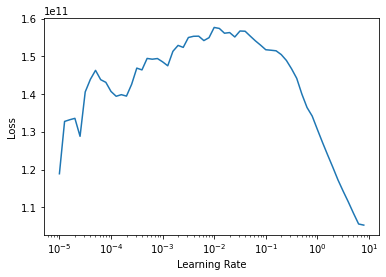

In [265]:
#learn.lr_find()
learn.lr_find(start_lr = 1e-05,end_lr =1e+05)

In [266]:
learn.fit_one_cycle(100,lr_max=0.01)

epoch,train_loss,valid_loss,accuracy,time
0,149200977920.000000,157080322048.000000,0.000000,00:00
1,148174110720.000000,157058449408.000000,0.000000,00:00
2,149818064896.000000,156997091328.000000,0.000000,00:00
3,150922412032.000000,156848603136.000000,0.000000,00:00
4,150259662848.000000,156427599872.000000,0.000000,00:00
5,149667790848.000000,155501330432.000000,0.000000,00:00
6,147877773312.000000,153478414336.000000,0.000000,00:00
7,145206018048.000000,148946878464.000000,0.000000,00:00
8,140215500800.000000,140676775936.000000,0.000000,00:00
9,132547715072.000000,128037683200.000000,0.000000,00:00


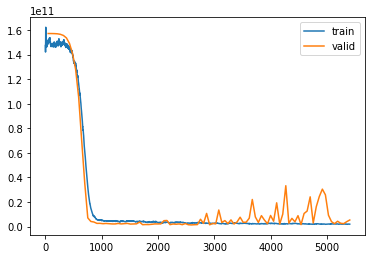

In [267]:
learn.recorder.plot_loss()

In [268]:
learn.show_results()

,Area,Elevator,Parking,Heating,CoolAir,Construction,Balcony,Sqft_m2,Rooms,Toilets,RatioEurM,Price,Price_pred
0,55.0,2.0,1.0,2.0,1.0,2.0,1.0,-0.136200,-0.723306,1.254805,0.522789,378000.0,369904.062500
1,54.0,1.0,1.0,1.0,2.0,2.0,2.0,-0.524951,-0.723306,-0.680351,-1.876545,70500.0,125455.476562
2,3.0,1.0,1.0,1.0,1.0,2.0,1.0,-1.655862,-1.774134,-0.680351,0.943336,192900.0,179389.062500
3,5.0,2.0,1.0,1.0,1.0,2.0,1.0,-0.383587,0.327523,-0.680351,-1.009522,172000.0,165195.921875
4,44.0,2.0,1.0,1.0,1.0,2.0,1.0,-0.701655,-0.723306,-0.680351,2.048143,450000.0,464696.437500
5,51.0,2.0,1.0,2.0,1.0,2.0,1.0,-0.772337,-1.774134,-0.680351,0.462078,285000.0,292719.250000
6,59.0,2.0,1.0,1.0,2.0,2.0,2.0,5.518357,1.378351,3.189962,-0.695218,695000.0,909439.125000
7,51.0,2.0,1.0,2.0,2.0,2.0,1.0,-0.418928,0.327523,1.254805,0.168644,300000.0,304409.750000
8,25.0,2.0,1.0,2.0,1.0,2.0,1.0,0.075846,1.378351,-0.680351,0.845946,450000.0,430412.656250


In [269]:
dls.show_batch()

,Area,Elevator,Parking,Heating,CoolAir,Construction,Balcony,Sqft_m2,Rooms,Toilets,RatioEurM,Price
0,St Pere - Sta Caterina - El Born,No,No,Yes,Yes,Not New,No,68.000000,2.0,1.0,4190.999999,285000.0
1,Vila Olímpica,No,Yes,No,No,New,No,94.000000,3.0,2.0,4520.999996,425000.0
2,Carmel,Yes,No,No,No,Not New,No,67.000000,3.0,1.0,2327.999989,156000.0
3,Putget - Farró,Yes,No,Yes,No,New,Yes,125.999999,2.0,1.0,7062.999971,890000.0
4,La salut,Yes,No,Yes,Yes,Not New,Yes,75.000000,2.0,1.0,2166.999975,162500.0
5,Carmel,Yes,No,No,Yes,Not New,No,80.000000,3.0,1.0,2499.999962,200000.0
6,Esquerra Alta de l´Eixample,Yes,No,Yes,No,Not New,Yes,101.999999,2.0,2.0,6765.000057,690000.0
7,Barceloneta,No,No,Yes,No,Not New,No,35.000002,1.0,1.0,5428.999994,190000.0
8,Sants,Yes,No,Yes,No,Not New,Yes,125.999999,4.0,2.0,2849.000026,359000.0
9,Esquerra Alta de l´Eixample,Yes,No,No,No,Not New,No,100.000000,2.0,2.0,5799.999975,580000.0


In [270]:
learn.validate(dl=test_dl)

(#2) [386453568.0,0.0]

In [271]:
preds = learn.get_preds(dl=test_dl)